1. Можно ли отобрать наиболее значимые признаки из имеющихся с помощью PCA? Ответ объясните

Ответ - нет.

PCA - это способ уменьшить размерность данных, потеряв наименьшее количество информации. 

Снижать размерность данных можно за счёт отбора признаков (корреляция, взаимная информация, переборные методы)

2. Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd(). Применить к данным на уроке и сравнить ответы.

3. Обучить любую модель классификации (из рассмотренных в курсе) на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

Начну работу с 3 задачи

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [142]:
def get_metrics(x1, x2):
  """
  Функция вычисляет евклидово расстояние
  """
  dots = np.linspace(0, 10, 100)
  q = 0.5
  value = list(map(lambda d: q ** d, dots))
  
  return np.sqrt(np.sum(np.square(x1 - x2)))

In [143]:
def get_knn(X_train, y_train, X_test, k):
  """
  Функция поиска k-ближайших соседей
  """
  answers = []
  for x in X_test:
    test_distances = []
        
    for i in range(len(X_train)):
        
      # расчет расстояния от классифицируемого объекта до
      # объекта обучающей выборки
      distance = get_metrics(x, X_train[i])
      
      # Записываем в список значение расстояния и ответа на объекте обучающей выборки
      test_distances.append((distance, y_train[i]))
    
    # создаем словарь со всеми возможными классами
    classes = {class_item: 0 for class_item in set(y_train)}
    
    # Сортируем список и среди первых k-элементов подсчитаем частоту появления разных классов
    numeric = 1
    for d in sorted(test_distances)[0:k]:
      classes[d[1]] += 1 / numeric
      numeric += 1

    # Записываем в список ответов наиболее часто встречающийся класс
    answers.append(sorted(classes, key=classes.get)[-1])
      
  return answers

In [144]:
def get_accuracy(pred, y):
  """
  Функция для вычисления точности
  """
  return sum(pred == y) / len(y)

In [145]:
X, y = load_iris(return_X_y=True)

In [146]:
X.shape

(150, 4)

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [148]:
k = 5

y_pred_train = get_knn(X_train, y_train, X_train, k)
y_pred = get_knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма на трейне при k = {k}: {get_accuracy(y_pred_train, y_train):.3f}')
print(f'Точность алгоритма на тесте при k = {k}: {get_accuracy(y_pred, y_test):.3f}')

Точность алгоритма на трейне при k = 5: 0.983
Точность алгоритма на тесте при k = 5: 0.967


In [149]:
def standard_scale(x):
  """ 
  Функция для стандартизации признаков
  """
  return (x - x.mean(axis=0)) / x.std(axis=0)

In [150]:
X = X.astype(float)

X = standard_scale(X)

In [151]:
X[:10]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ],
       [-0.53717756,  1.93979142, -1.16971425, -1.05217993],
       [-1.50652052,  0.78880759, -1.34022653, -1.18381211],
       [-1.02184904,  0.78880759, -1.2833891 , -1.3154443 ],
       [-1.74885626, -0.36217625, -1.34022653, -1.3154443 ],
       [-1.14301691,  0.09821729, -1.2833891 , -1.44707648]])

In [152]:
# Найдём собственные векторы и собственные значения
covariance_matrix = X.T @ X
eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# Формируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# Сортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения и собственные векторы в порядке убывания:\n')
for eig_pair in eig_pairs:
  print(eig_pair)

Собственные значения и собственные векторы в порядке убывания:

(437.77467247979934, array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654]))
(137.10457072021043, array([-0.37741762, -0.92329566, -0.02449161, -0.06694199]))
(22.01353133569724, array([-0.71956635,  0.24438178,  0.14212637,  0.63427274]))
(3.107225464292861, array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))


Оценим долю дисперсии, которая описывается найденными компонентами.

In [153]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

print(f'Доля дисперсии, описываемая каждой из компонент: \n{var_exp}\n')
print(f'Кумулятивная доля дисперсии по компонентам: \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент: 
[72.9624454132999, 22.850761786701742, 3.6689218892828745, 0.517870910715477]

Кумулятивная доля дисперсии по компонентам: 
[ 72.96244541  95.8132072   99.48212909 100.        ]


Таким образом, первая главная компонента описывает почти 73% информации, а первые две в сумме - 95.8%. В то же время последняя компонента описывает всего 0.5% и может быть отброжена без страха значительных потерь в качестве нашего анализа. Мы отбросим последние две компоненты, оставив первые две.

In [154]:
# Сформируем вектор весов из собственных векторов, соответствующий первым двум главным компонентам
W = np.hstack([eig_pairs[i][1].reshape(4,1) for i in range(2)])

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [155]:
# Сформируем новую матрицу "объекты-признаки"
Z = X.dot(W)
Z[:10]

array([[-2.26470281, -0.4800266 ],
       [-2.08096115,  0.67413356],
       [-2.36422905,  0.34190802],
       [-2.29938422,  0.59739451],
       [-2.38984217, -0.64683538],
       [-2.07563095, -1.48917752],
       [-2.44402884, -0.0476442 ],
       [-2.23284716, -0.22314807],
       [-2.33464048,  1.11532768],
       [-2.18432817,  0.46901356]])

In [156]:
print(Z.shape)
print(X.shape)
print(W.shape)

(150, 2)
(150, 4)
(4, 2)


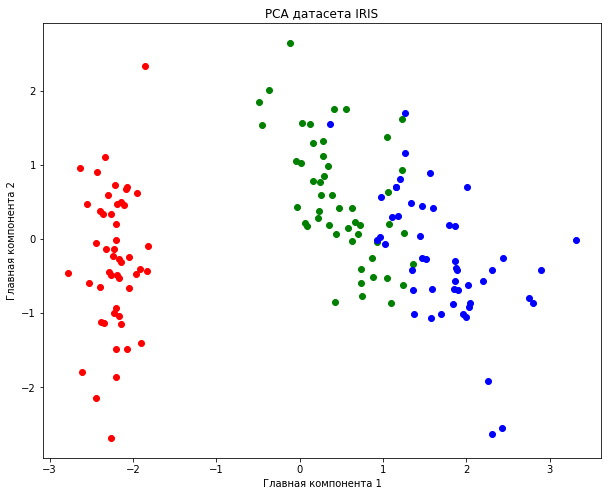

In [157]:
plt.figure(figsize=(10, 8))

for c, i in zip("rgb", [0, 1, 2]):
  plt.scatter(Z[y == i, 0], Z[y == i, 1], c=c)
  
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

In [158]:
Z_train, Z_test, y_z_train, y_z_test = train_test_split(Z, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [159]:
y_z_pred_train = get_knn(Z_train, y_z_train, Z_train, k)
y_z_pred = get_knn(Z_train, y_z_train, Z_test, k)

print(f'Точность алгоритма на трейне при k = {k}: {get_accuracy(y_z_pred_train, y_z_train):.3f}')
print(f'Точность алгоритма на тесте при k = {k}: {get_accuracy(y_z_pred, y_z_test):.3f}')

Точность алгоритма на трейне при k = 5: 0.975
Точность алгоритма на тесте при k = 5: 0.933


Вернёмся к задаче №2:

"Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd(). Применить к данным на уроке и сравнить ответы."

In [160]:
U, s, W = np.linalg.svd(X)

In [161]:
V = W.T

In [162]:
D = np.zeros_like(X, dtype=float)
D[np.diag_indices(min(X.shape))] = s

In [163]:
print(U.shape)
print(V.shape)
print(D.shape)

(150, 150)
(4, 4)
(150, 4)


In [164]:
print(U)

[[-1.08239531e-01 -4.09957970e-02  2.72186462e-02 ...  5.43380310e-02
   1.96438400e-03  2.46978090e-03]
 [-9.94577561e-02  5.75731483e-02  5.00034005e-02 ...  5.12936114e-03
   8.48544595e-02  5.83496936e-03]
 [-1.12996303e-01  2.92000319e-02 -9.42089147e-03 ...  2.75184277e-02
   1.78604309e-01  1.49419118e-01]
 ...
 [ 7.27030413e-02 -2.29793601e-02 -3.84023516e-02 ...  9.89532683e-01
  -1.25488246e-02 -7.17729676e-04]
 [ 6.56112167e-02 -8.63643414e-02 -1.98939364e-01 ... -1.41206665e-02
   9.52049996e-01 -2.32048811e-02]
 [ 4.59137323e-02  2.07800179e-03 -1.12588405e-01 ... -8.30595907e-04
  -2.19201906e-02  9.77300244e-01]]


In [165]:
print(V)

[[ 0.52106591 -0.37741762  0.71956635  0.26128628]
 [-0.26934744 -0.92329566 -0.24438178 -0.12350962]
 [ 0.5804131  -0.02449161 -0.14212637 -0.80144925]
 [ 0.56485654 -0.06694199 -0.63427274  0.52359713]]


In [166]:
print(D)

[[20.92306556  0.          0.          0.        ]
 [ 0.         11.7091661   0.          0.        ]
 [ 0.          0.          4.69185798  0.        ]
 [ 0.          0.          0.          1.76273239]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.  

In [167]:
trunc = 2
U_truncate = U[:, :trunc]
S_truncate = D[:trunc]
V_truncate = V[:trunc, :]

In [168]:
X_truncate = U_truncate @ np.diag(S_truncate)

In [169]:
X_truncate.shape

(150,)

In [170]:
D_train, D_test, y_d_train, y_d_test = train_test_split(X_truncate, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [171]:
k = 5
y_d_pred_train = get_knn(D_train, y_d_train, D_train, k)
y_d_pred = get_knn(D_train, y_d_train, D_test, k)

print(f'Точность алгоритма на трейне при k = {k}: {get_accuracy(y_d_pred_train, y_d_train):.3f}')
print(f'Точность алгоритма на тесте при k = {k}: {get_accuracy(y_d_pred, y_d_test):.3f}')

Точность алгоритма на трейне при k = 5: 0.967
Точность алгоритма на тесте при k = 5: 0.800


При использовании SVD-разложения точность на трейне очень близки, а вот на тесте точность хуже при использовании SVD